In [1]:
! pip install git+https://github.com/pycaret/pycaret.git@master

  Cloning https://github.com/pycaret/pycaret.git (to revision master) to /private/var/folders/8h/ddzhh79s6_d_5_9q2vdhtff40000gn/T/pip-req-build-sncj01lo
  Running command git clone --filter=blob:none --quiet https://github.com/pycaret/pycaret.git /private/var/folders/8h/ddzhh79s6_d_5_9q2vdhtff40000gn/T/pip-req-build-sncj01lo
  Resolved https://github.com/pycaret/pycaret.git to commit 58ec3c282d58e94727f9d5b77b49f241e9103ab3
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [2]:
# numpy and pandas will be used for data manipulation
import numpy as np
import pandas as pd
# matplotlib will be used for visually representing our data
import matplotlib.pyplot as plt
# Yfinance for importing historical prices
import yfinance as yfin

In [3]:
# Setting ticker
ticker = 'AMZN'
ticker = yfin.Ticker(ticker)

# Importing data
data = ticker.history(period='5y')

<Axes: xlabel='Date', ylabel='Amazon Stock Price'>

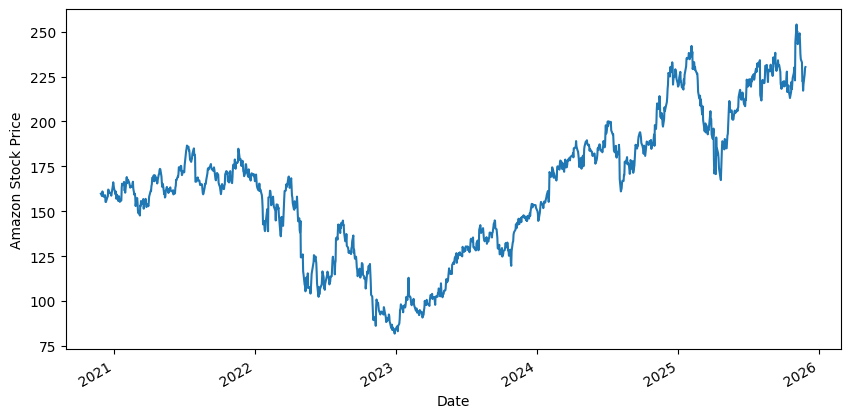

In [4]:
plt.ylabel("Amazon Stock Price")
data['Close'].plot(figsize=(10,5))

In [ ]:
# MOVING AVERAGES
data['MA20'] = data['Close'].shift(1).rolling(window=20).mean()
data['EMA20']= data['Close'].shift(1).ewm(span=20, adjust=False).mean()
data['MA50'] = data['Close'].shift(1).rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = data['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
window_length = 14
avg_gain = gain.rolling(window=window_length).mean()
avg_loss = loss.rolling(window=window_length).mean()
rs = avg_gain / avg_loss
data['RSI'] = 100 - (100 / (1 + rs))

In [6]:
correlations=data.corr()
correlations

,Open,High,Low,Close,Volume,Dividends,Stock Splits,MA20,EMA20,MA50,RSI
Open,1.000000,0.998997,0.998986,0.997722,-0.375995,NaN,-0.026482,0.978058,0.983716,0.950306,0.160934
High,0.998997,1.000000,0.998824,0.999020,-0.366100,NaN,-0.025085,0.978722,0.984359,0.952513,0.163283
Low,0.998986,0.998824,1.000000,0.999039,-0.387551,NaN,-0.026215,0.975626,0.981467,0.946773,0.174348
Close,0.997722,0.999020,0.999039,1.000000,-0.377424,NaN,-0.026822,0.976516,0.982211,0.949236,0.174036
Volume,-0.375995,-0.366100,-0.387551,-0.377424,1.000000,NaN,0.080053,-0.343132,-0.344159,-0.299797,-0.148560
Dividends,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Stock Splits,-0.026482,-0.025085,-0.026215,-0.026822,0.080053,NaN,1.000000,-0.036506,-0.032348,-0.019588,0.024977
MA20,0.978058,0.978722,0.975626,0.976516,-0.343132,NaN,-0.036506,1.000000,0.998900,0.982277,-0.013723
EMA20,0.983716,0.984359,0.981467,0.982211,-0.344159,NaN,-0.032348,0.998900,1.000000,0.983209,0.019924
MA50,0.950306,0.952513,0.946773,0.949236,-0.299797,NaN,-0.019588,0.982277,0.983209,1.000000,-0.054321


In [7]:
# Dropping the NaN values
data = data.dropna()

In [8]:
features = ["MA20", "EMA20", "MA50", "RSI", "Close"]
data_for_split = data[features]

# Sample 80% of the data for modeling
data1 = data_for_split.sample(frac=0.8, random_state=786)

# The remaining 20% will be the unseen data
data_unseen = data_for_split.drop(data1.index)

data1.reset_index(drop=True, inplace=True)
data_unseen.reset_index(drop=True, inplace=True)

print('Data for Modeling: ' + str(data1.shape))
print('Unseen Data For Predictions: ' + str(data_unseen.shape))

Data for Modeling: (965, 5)
Unseen Data For Predictions: (241, 5)


In [9]:
data_unseen

,MA20,EMA20,MA50,RSI,Close
0,163.892649,163.820730,161.104260,44.556965,163.447495
1,164.774100,163.942024,161.291590,59.322980,166.411499
2,164.793499,164.017001,161.549140,32.578340,159.037003
3,163.410975,161.747861,161.641670,24.486217,154.646500
4,163.049250,161.071541,161.577630,33.383469,157.307007
...,...,...,...,...,...
236,227.959000,225.183722,226.973199,40.963494,222.410004
237,224.129500,223.581440,225.650600,49.162744,220.070007
238,219.511500,220.028503,225.349600,51.697465,221.089996
239,222.345500,224.767565,225.491000,77.921298,254.000000


In [10]:
from pycaret.regression import *
s = setup(data = data1,
             target = 'Close',
             numeric_imputation = 'mean',
             normalize = True,
             remove_outliers = True,
             transformation = True,
             session_id = 123,
             n_jobs=-1)

,Description,Value
0,Session id,123
1,Target,Close
2,Target type,Regression
3,Original data shape,"(965, 5)"
4,Transformed data shape,"(931, 5)"
5,Transformed train set shape,"(641, 5)"
6,Transformed test set shape,"(290, 5)"
7,Numeric features,4
8,Preprocess,True
9,Imputation type,simple


In [11]:
# LINEAR REGRESSION MODEL
# Defining and training the LRM using PyCaret
lr  = create_model('lr')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4053,17.0352,4.1274,0.9903,0.0276,0.0220
1,2.5344,10.3816,3.2220,0.9937,0.0220,0.0173
2,3.4596,21.0493,4.5880,0.9894,0.0309,0.0229
3,3.5833,21.4335,4.6296,0.9880,0.0279,0.0224
4,3.2222,19.1834,4.3799,0.9892,0.0254,0.0191
5,3.1853,19.0368,4.3631,0.9838,0.0254,0.0192
6,2.9237,13.5394,3.6796,0.9919,0.0244,0.0191
7,2.8982,14.9589,3.8677,0.9900,0.0274,0.0194
8,2.7029,11.7386,3.4262,0.9930,0.0231,0.0178


In [12]:
tuned_lr = tune_model(lr)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.4053,17.0352,4.1274,0.9903,0.0276,0.0220
1,2.5344,10.3816,3.2220,0.9937,0.0220,0.0173
2,3.4596,21.0493,4.5880,0.9894,0.0309,0.0229
3,3.5833,21.4335,4.6296,0.9880,0.0279,0.0224
4,3.2222,19.1834,4.3799,0.9892,0.0254,0.0191
5,3.1853,19.0368,4.3631,0.9838,0.0254,0.0192
6,2.9237,13.5394,3.6796,0.9919,0.0244,0.0191
7,2.8982,14.9589,3.8677,0.9900,0.0274,0.0194
8,2.7029,11.7386,3.4262,0.9930,0.0231,0.0178


Fitting 10 folds for each of 2 candidates, totalling 20 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


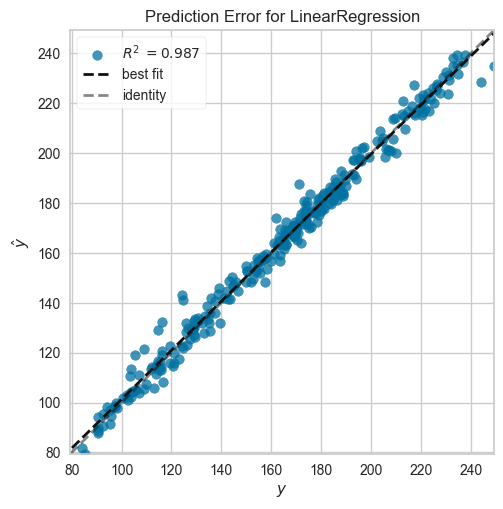

In [13]:
plot_model(tuned_lr, plot = 'error')

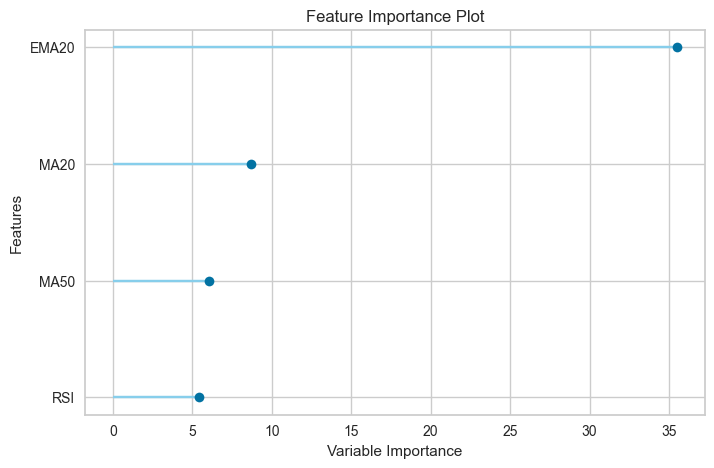

In [14]:
plot_model(tuned_lr, plot='feature')

In [15]:
evaluate_model(tuned_lr)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [16]:
predict_model(tuned_lr)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,3.2547,20.0020,4.4724,0.9871,0.0300,0.0213


,MA20,EMA20,MA50,RSI,Close,prediction_label
171,171.597855,172.226334,169.670441,60.688908,177.035004,176.156876
389,213.018509,212.595566,201.848404,53.692673,220.460007,215.436066
204,187.401001,185.401276,179.367996,39.828876,187.539993,183.212799
756,206.798004,204.970352,192.996399,72.933586,217.610001,215.237595
335,169.093292,169.884933,166.250763,60.863064,171.648499,174.017838
...,...,...,...,...,...,...
897,224.807495,220.576477,226.039001,15.687199,203.800003,208.798035
243,159.684402,160.514069,153.942444,44.788750,157.784500,159.490677
735,154.339996,155.361176,151.046600,73.710365,171.809998,164.126099
202,143.127274,139.626495,150.488464,22.361557,114.772499,129.151566


In [17]:
final_lr= finalize_model(tuned_lr)
print(final_lr)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MA20', 'EMA20', 'MA50', 'RSI'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator', LinearRegression(n_jobs=-1))])


In [18]:
unseen_predictions = predict_model(final_lr, data=data_unseen)
unseen_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Linear Regression,2.9658,15.9329,3.9916,0.9891,0.0267,0.0195


,MA20,EMA20,MA50,RSI,Close,prediction_label
0,163.892654,163.820724,161.104263,44.556965,163.447495,162.170959
1,164.774094,163.942017,161.291595,59.322979,166.411499,167.898636
2,164.793503,164.016998,161.549133,32.578339,159.037003,158.200119
3,163.410980,161.747864,161.641663,24.486217,154.646500,152.898605
4,163.049255,161.071548,161.577637,33.383469,157.307007,155.315826


In [19]:
# RANDOM FOREST REGRESSOR
# Defining and training the RFR using PyCaret
rf = create_model('rf')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,2.8137,13.6285,3.6917,0.9922,0.0227,0.0171
1,2.5709,11.8113,3.4368,0.9928,0.0210,0.0168
2,2.8899,19.6150,4.4289,0.9901,0.0343,0.0207
3,3.2827,24.7146,4.9714,0.9861,0.0328,0.0219
4,2.7420,15.2382,3.9036,0.9914,0.0232,0.0165
5,3.2127,24.1085,4.9100,0.9795,0.0305,0.0198
6,2.1290,8.3799,2.8948,0.9950,0.0196,0.0140
7,2.7730,14.8288,3.8508,0.9901,0.0294,0.0191
8,2.5030,15.6665,3.9581,0.9907,0.0265,0.0165


In [20]:
tuned_rf = tune_model(rf)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,3.1936,17.7244,4.2100,0.9899,0.0248,0.0190
1,2.8218,17.0297,4.1267,0.9896,0.0241,0.0180
2,3.3689,24.0294,4.9020,0.9879,0.0371,0.0240
3,3.5249,29.9066,5.4687,0.9832,0.0337,0.0225
4,3.1401,19.8080,4.4506,0.9889,0.0255,0.0186
5,3.4761,28.2922,5.3190,0.9760,0.0338,0.0216
6,2.1136,7.9723,2.8235,0.9952,0.0191,0.0140
7,2.7711,13.5803,3.6851,0.9909,0.0269,0.0187
8,2.5370,17.7678,4.2152,0.9895,0.0274,0.0166


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


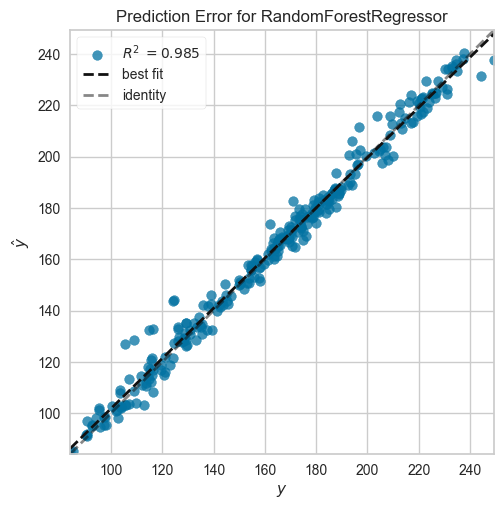

In [21]:
plot_model(tuned_rf, plot = 'error')

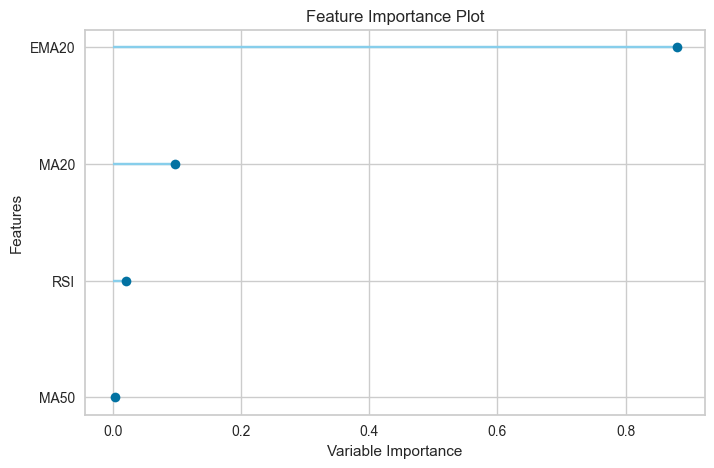

In [22]:
plot_model(tuned_rf, plot = 'feature')

In [23]:
evaluate_model(tuned_rf)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [24]:
final_rf = finalize_model(tuned_rf)
print(final_rf)

Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(include=['MA20', 'EMA20', 'MA50', 'RSI'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=[],
                                    transformer=SimpleImputer(strategy='most_frequent'))),
                ('remove_outliers',
                 TransformerWrapper(transformer=RemoveOutliers(random_state=123))),
                ('transformation',
                 TransformerWrapper(transformer=PowerTransformer(standardize=False))),
                ('normalize', TransformerWrapper(transformer=StandardScaler())),
                ('actual_estimator',
                 RandomForestRegressor(n_jobs=-1, random_state=123))])


In [25]:
unseenrf_predictions = predict_model(final_rf, data=data_unseen)
unseenrf_predictions.head()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,2.3634,10.5889,3.2541,0.9928,0.0235,0.0160


,MA20,EMA20,MA50,RSI,Close,prediction_label
0,163.892654,163.820724,161.104263,44.556965,163.447495,163.002385
1,164.774094,163.942017,161.291595,59.322979,166.411499,165.646588
2,164.793503,164.016998,161.549133,32.578339,159.037003,160.410407
3,163.410980,161.747864,161.641663,24.486217,154.646500,151.712361
4,163.049255,161.071548,161.577637,33.383469,157.307007,156.718021


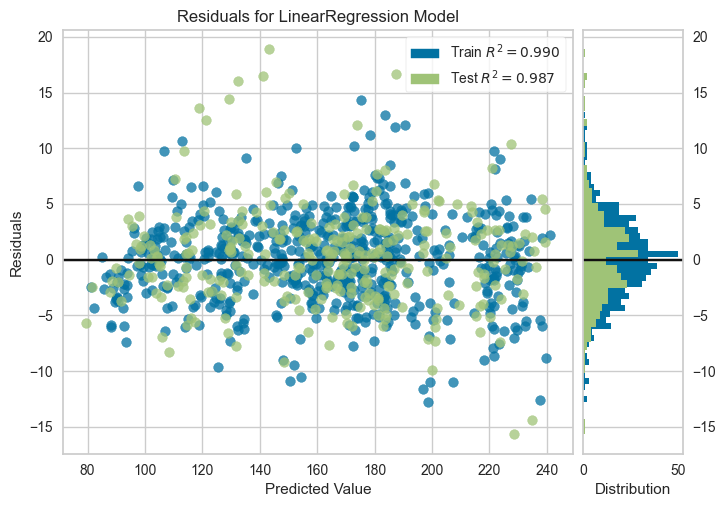

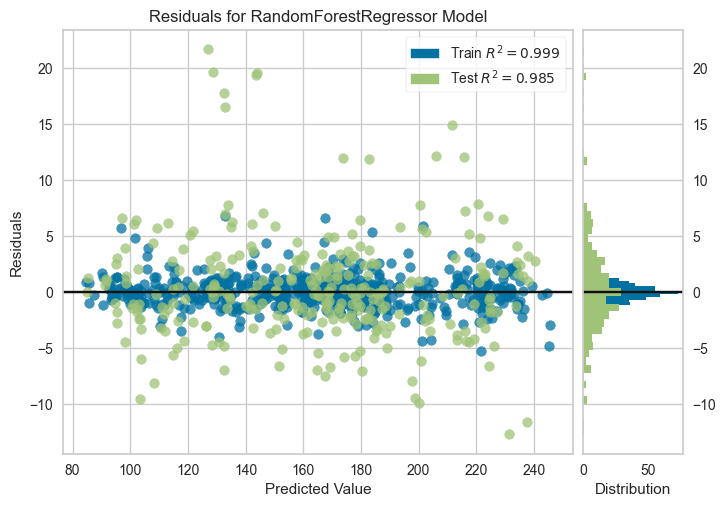

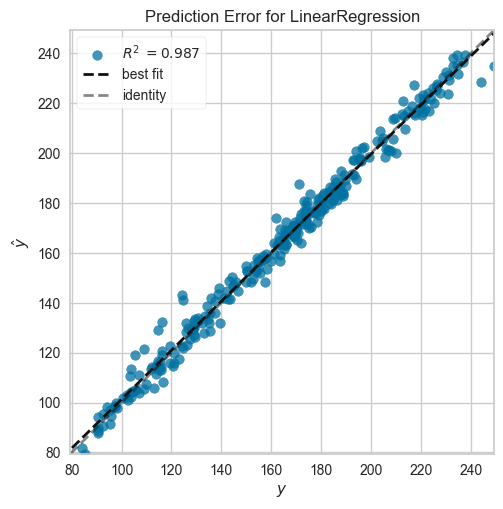

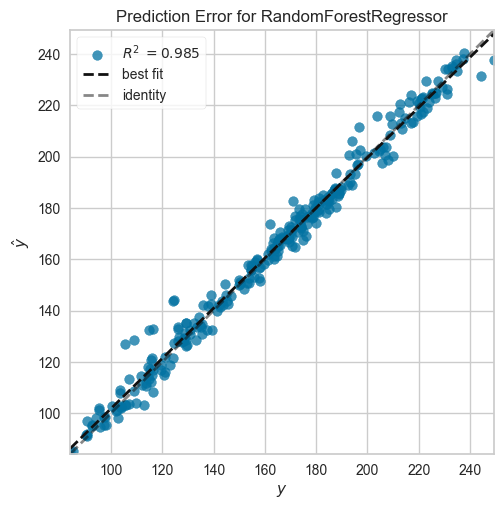

In [26]:
# Comparing Linear Regression Model VS Random Forest Regressor Visually
plot_model(lr, plot='residuals')
plot_model(rf, plot='residuals')

plot_model(lr, plot='error')
plot_model(rf, plot='error')